# Notebook 2: The Inverse Problem and Gradient-Based Optimization
  
**Description:** This notebook details the mathematical formulation of the Magnetotelluric Inverse Problem. It introduces the objective function with Tikhonov regularization, derives the gradient using the Adjoint State Method, validates the gradient using the Taylor Test, and demonstrates a deterministic inversion using the L-BFGS-B algorithm.

## 1. Mathematical Formulation

The goal of the inverse problem is to find a conductivity model $\mathbf{m}$ that reproduces the observed data $\mathbf{d}_{obs}$ within a specified noise level. Since MT inversion is non-unique and ill-posed, we formulate it as an optimization problem where we minimize a cost function $\Phi(\mathbf{m})$.

### 1.1. The Objective Function

We define the global objective function as:

$$
\Phi(\mathbf{m}) = \Phi_d(\mathbf{m}) + \beta \Phi_m(\mathbf{m})
$$

Where:
* **$\Phi_d(\mathbf{m})$ (Data Misfit):** Measures how well the predicted data matches the observed data.
    $$\Phi_d = \frac{1}{2} \sum_{i} \left( \frac{F_i(\mathbf{m}) - d_{obs, i}}{\epsilon_i} \right)^2$$
    Here, $F(\mathbf{m})$ is the forward operator (Notebook 1) and $\epsilon_i$ is the standard deviation of the noise.

* **$\Phi_m(\mathbf{m})$ (Model Norm / Regularization):** Penalizes complexity (roughness) to ensure a stable, smooth solution (Tikhonov Regularization).
    $$\Phi_m = \frac{1}{2} || \mathbf{L} \mathbf{m} ||^2$$
    Here, $\mathbf{L}$ is the Laplacian operator (spatial derivative).

* **$\beta$ (Trade-off Parameter):** Controls the balance between fitting the data and smoothing the model.

## 2. Gradient Computation: The Adjoint State Method

To minimize $\Phi(\mathbf{m})$ using gradient-based methods (like L-BFGS), we need the derivative of the objective function with respect to the model parameters: $\nabla_m \Phi$.

Calculating the gradient using Finite Differences (perturbing every cell) would require $N$ forward simulations (where $N$ is the number of cells). For 3D problems, this is computationally impossible.

Instead, we use the **Adjoint State Method**, which computes the exact gradient with the cost of only **one extra forward simulation** (back-propagation of the residual errors).

The gradient is given by:
$$
\nabla \Phi = \mathbf{J}^T \delta \mathbf{d} + \beta \mathbf{L}^T \mathbf{L} \mathbf{m}
$$
Where $\mathbf{J}^T \delta \mathbf{d}$ is efficiently computed by solving the adjoint system:
$$\mathbf{A}^T \lambda = -\delta \mathbf{d}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

sys.path.append(os.path.abspath('..'))

from pymtinv.mesh import create_padded_mesh
from pymtinv.forward import MT2DForward
from pymtinv.backward import MT2DGradient
from pymtinv.visualization import MT2DVisualizer
from scipy.optimize import minimize

## 3. Setup: Synthetic Experiment

Let's create a "True Model" with a conductive anomaly, generate synthetic noisy data, and try to recover the model.

1.  **Background:** $100 \Omega m$
2.  **Anomaly:** A conductive block ($10 \Omega m$) in the center.

In [2]:
# 1. Define Mesh
mesh = create_padded_mesh(
    core_width=4000, core_depth=4000,
    core_dy=200, core_dz=100,
    pad_factor=1.4, n_pad_y=5, n_pad_z=5
)

# 2. Create True Model (Log Conductivity)
sigma_true = np.ones((mesh.Ny, mesh.Nz)) * 0.01
# Add Anomaly
cy, cz = mesh.Ny // 2, mesh.Nz // 2
sigma_true[cy-2:cy+2, 5:9] = 0.1 # Conductive Block

m_true = np.log10(sigma_true).flatten()

# 3. Generate Synthetic Data
freqs = np.logspace(2, -1, 8)
fwd = MT2DForward(mesh)
Z_true, _ = fwd.solve_te(freqs, sigma_true)

# Add 5% Noise
Z_obs = []
data_std = []
np.random.seed(42)
for f in freqs:
    val = Z_true[f]
    noise = 0.05 * np.abs(val) * (np.random.randn(*val.shape) + 1j*np.random.randn(*val.shape))
    Z_obs.append(val + noise)
    data_std.append(0.05 * np.abs(val))

print("Synthetic data generated with 5% Gaussian noise.")

 Mesh Oluşturuldu: 30x45 hücre.
 Toplam Boyut: 10.1 km x 5.5 km
Synthetic data generated with 5% Gaussian noise.


## 4. Validation: The Taylor Test

Before running an inversion, we **must** prove that our gradient calculation is correct. We use the **Taylor Test**.

If the gradient $\nabla \Phi$ is correct, the difference between the function value and its first-order Taylor approximation should decrease quadratically as we reduce the perturbation step size $h$.

$$ \Phi(\mathbf{m} + h \Delta \mathbf{m}) - \Phi(\mathbf{m}) \approx h \nabla \Phi \cdot \Delta \mathbf{m} $$

We check the ratio:
$$ R(h) = \frac{|| \Phi(\mathbf{m} + h \Delta \mathbf{m}) - \Phi(\mathbf{m}) ||}{|| h \nabla \Phi \cdot \Delta \mathbf{m} ||} $$

Ideally, as $h \to 0$, $R(h) \to 1$.

In [3]:
# Initialize Gradient Engine
grad_engine = MT2DGradient(fwd, Z_obs, data_std)

# Define a random perturbation dm
m0 = np.log10(np.ones((mesh.Ny, mesh.Nz)) * 0.01).flatten()
dm = np.random.randn(len(m0))

# Compute Gradient at m0
grad0, phi0 = grad_engine.compute_gradient(freqs, 10**m0.reshape(mesh.Ny, mesh.Nz), beta=0.0)
grad0 = grad0.flatten()

# Taylor Test Loop
print(f"{'h':<10} | {'Phi':<15} | {'Error1':<15} | {'Ratio':<10}")
print("-"*60)

h = 0.1
for i in range(5):
    m_pert = m0 + h * dm
    _, phi_new = grad_engine.compute_gradient(freqs, 10**m_pert.reshape(mesh.Ny, mesh.Nz), beta=0.0)
    
    # Taylor approximations
    pred_linear = phi0 + h * np.dot(grad0, dm)
    diff = np.abs(phi_new - phi0)
    error = np.abs(phi_new - pred_linear)
    
    # Ratio should ideally act like O(h^2)
    # Or simply: Ratio of (Actual Diff / Predicted Diff) -> 1.0
    ratio = (phi_new - phi0) / (h * np.dot(grad0, dm))
    
    print(f"{h:<10.1e} | {phi_new:<15.4e} | {error:<15.4e} | {ratio:<10.4f}")
    h /= 2.0

h          | Phi             | Error1          | Ratio     
------------------------------------------------------------
1.0e-01    | 1.0762e+03      | 5.9615e+01      | 1.5696    
5.0e-02    | 1.1733e+03      | 1.4859e+01      | 1.2840    
2.5e-02    | 1.2112e+03      | 3.0790e+00      | 1.1177    
1.3e-02    | 1.2270e+03      | 4.1185e-01      | 1.0315    
6.3e-03    | 1.2340e+03      | 7.8651e-02      | 0.9880    


## 5. Deterministic Inversion (L-BFGS)

Now that the gradient is validated, we perform the inversion. We use the **L-BFGS-B** (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) algorithm, which is efficient for large-scale problems.

We include regularization ($\beta=10.0$) to stabilize the result.

In [4]:
# Wrapper function for scipy.minimize
beta_val = 10.0

def objective_function(m_vec):
    sigma_curr = 10**m_vec.reshape((mesh.Ny, mesh.Nz))
    g, phi = grad_engine.compute_gradient(freqs, sigma_curr, beta=beta_val)
    return phi, g.flatten()

# Initial Model (Homogeneous)
m_init = np.log10(np.ones((mesh.Ny, mesh.Nz)) * 0.01).flatten()

print("Starting L-BFGS Inversion...")
result = minimize(
    fun=objective_function,
    x0=m_init,
    method='L-BFGS-B',
    jac=True,
    options={'maxiter': 50, 'disp': True}
)

print(f"Inversion Complete. Final Phi: {result.fun:.2f}")
m_rec = result.x.reshape((mesh.Ny, mesh.Nz))

Starting L-BFGS Inversion...
Inversion Complete. Final Phi: 250.04


## 6. Results Visualization

Comparison of the True Model vs. The Recovered Model.

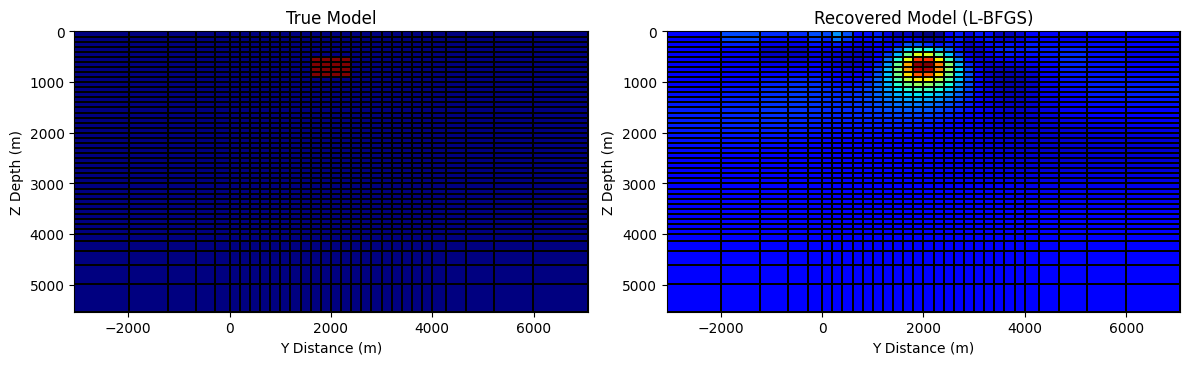

In [5]:
plt.figure(figsize=(12, 5))

ax1 = plt.subplot(1, 2, 1)
MT2DVisualizer.plot_model(mesh, np.log10(sigma_true), ax=ax1, title="True Model")

ax2 = plt.subplot(1, 2, 2)
MT2DVisualizer.plot_model(mesh, m_rec, ax=ax2, title="Recovered Model (L-BFGS)")

plt.tight_layout()
plt.show()